<a href="https://colab.research.google.com/github/smahesh2694/NEU_XAI/blob/master/xai_shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import os
import keras
import cv2
import matplotlib.pyplot as plt
from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import SGD
from skimage.segmentation import mark_boundaries
from xml.etree import ElementTree

Using TensorFlow backend.


In [4]:
saved_model = load_model('/content/drive/My Drive/xai_model/LG_model.h5')














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [0]:
annotation = '/content/drive/My Drive/NEU-DET/ANNOTATIONS/patches_212.xml'
image_path = "/content/drive/My Drive/NEU orig/Pa/Pa_212.bmp"

In [0]:
labels = {0: 'Crazing', 1: 'Inclusion', 2: 'Pitted Surface', 3: 'Patches', 4: 'Rolled-in Scale', 5: 'Scratches'}

In [0]:
shap_Cr = '/content/drive/My Drive/NEU orig/Cr/*.bmp'
shap_In = '/content/drive/My Drive/NEU orig/In/*.bmp'
shap_PS = '/content/drive/My Drive/NEU orig/PS/*.bmp'
shap_Pa = '/content/drive/My Drive/NEU orig/Pa/*.bmp'
shap_RS = '/content/drive/My Drive/NEU orig/RS/*.bmp'
shap_Sc = '/content/drive/My Drive/NEU orig/Sc/*.bmp'

shap_data = [shap_Cr, shap_In, shap_PS, shap_Pa, shap_RS, shap_Sc]

[[1.7903918e-05 6.0450856e-07 2.7348185e-07 9.9997187e-01 9.8635041e-08
  9.2711989e-06]]
[3]
Patches


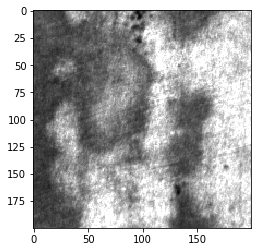

In [8]:
img = image.load_img(image_path, target_size=(200,200))
plt.imshow(img)

img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img /= 255
result = saved_model.predict(img)
print(result)

prediction = result.argmax(axis=-1)
print(prediction)

output = labels[int(prediction)]
print(output)

[[1, 76, 36, 199], [19, 1, 114, 136], [121, 72, 166, 195], [117, 1, 173, 26]]


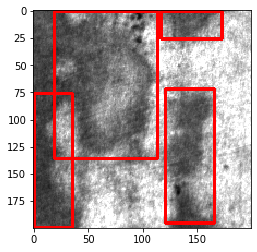

In [9]:
b_img = cv2.imread(image_path)

def extract_boxes(filename):
	tree = ElementTree.parse(filename)
	root = tree.getroot()	
	boxes = list()
	for box in root.findall('.//bndbox'):
		xmin = int(box.find('xmin').text)
		ymin = int(box.find('ymin').text)
		xmax = int(box.find('xmax').text)
		ymax = int(box.find('ymax').text)
		coors = [xmin, ymin, xmax, ymax]
		boxes.append(coors)
	return boxes 

boxes = extract_boxes(annotation)
print(boxes)

for i in range(len(boxes)):
  pt1 = boxes[i][0], boxes[i][1]
  pt2 = boxes[i][2], boxes[i][3]
  #print(pt1, pt2)
  cv2.rectangle(b_img, pt1, pt2, (255, 0, 0), 2)
  plt.imshow(b_img)

In [10]:
!pip install shap

     |████████████████████████████████| 266kB 4.8MB/s 
  Created wheel for shap: filename=shap-0.32.1-cp36-cp36m-linux_x86_64.whl size=376815 sha256=4b3024f66d7303994b20fbcb0c2fe1e95afa700180c152201a85e114636cbec2
  Stored in directory: /root/.cache/pip/wheels/8e/b2/50/8fadb5a59789cb5bdeb01b800223be540651ae92915172050b
Successfully built shap


In [0]:
# %%time
# import glob
# cv_img = []

# for i in range(len(shap_data)):
#   for ig in glob.glob(shap_data[i]):
#     n = cv2.imread(ig)
#     cv_img.append(n)

# shap_background = np.array(cv_img)

#np.save('/content/drive/My Drive/XAI_results/shap_background.npy', shap_background)


In [11]:
shap_background = np.load('/content/drive/My Drive/XAI_results/shap_background.npy')
shap_background.shape

(1800, 200, 200, 3)

(1, 200, 200, 3)

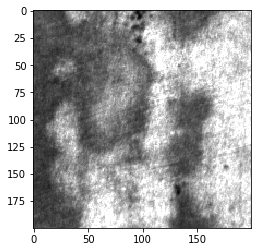

In [12]:
shap_test = image.load_img(image_path) #, grayscale=True)
plt.imshow(shap_test)

shap_test = image.img_to_array(shap_test)
shap_test = np.expand_dims(shap_test, axis=0)
#shap_test /= 255
#shap_test = preprocess_input(shap_test)
shap_test.shape

In [0]:
# for i in range(len(saved_model.layers)):
#   print(i , saved_model.layers[i])

In [0]:
test_input = np.load('/content/drive/My Drive/xai_model/grad_test_input.npy')

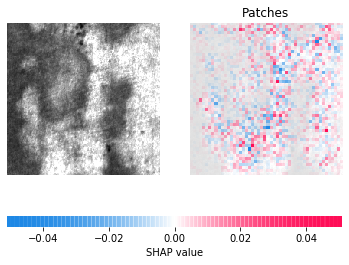

CPU times: user 3.97 s, sys: 2.88 s, total: 6.85 s
Wall time: 8.09 s


In [15]:
%%time
import keras.backend as K
import shap
m = 16

def map2layer(x, layer):
  feed_dict = dict(zip([saved_model.layers[0].input], [preprocess_input(x.copy())]))  
  return K.get_session().run(saved_model.layers[layer].input, feed_dict)

e = shap.GradientExplainer((saved_model.layers[m].input, saved_model.layers[-1].output),
                           map2layer(preprocess_input(shap_background.copy()),m), local_smoothing = 0)    #shap_background.copy()  test_input.copy()

shap_values, indexes = e.shap_values(map2layer(shap_test, m), ranked_outputs=1)

index_names = np.vectorize(lambda l: labels[l])(indexes)

shap.image_plot(shap_values, shap_test, index_names)

In [16]:
len(shap_values)

1

In [0]:
q = shap_values[0]

In [18]:
q.shape

(1, 50, 50, 128)

In [19]:
sv = shap_values[0][0].sum(-1)
svs = (sv).shape
svs

(50, 50)

In [20]:
len(shap_values[0][0].shape)

3

In [21]:
shap_values[0].shape

(1, 50, 50, 128)

In [22]:
(shap_values[0].sum(-1)).shape    # row sum

(1, 50, 50)

In [0]:
abs_vals = np.abs(shap_values[0].sum(-1))

In [24]:
abs_vals.shape

(1, 50, 50)

In [0]:
max_val = np.nanpercentile(abs_vals, 99.9)

In [26]:
max_val

0.050817128526734034

In [27]:
sv.max()

0.05438287692367583

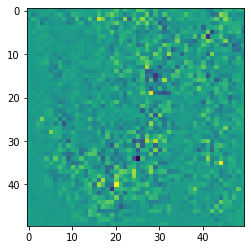

In [28]:
plt.imshow(sv)

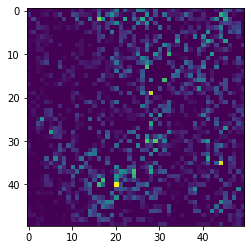

In [29]:
sv_p = np.zeros(sv.shape)
for i in range(sv.shape[0]):
  for j in range(sv.shape[1]):
    if sv[i][j] < 0:
      sv_p[i][j] = 0
    else:
      sv_p[i][j] = sv[i][j]

plt.imshow(sv_p)

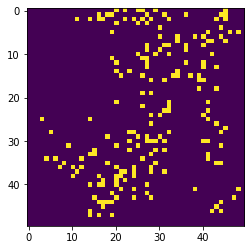

In [30]:
sv_p = sv_p / np.amax(sv_p)

for i in range(sv_p.shape[0]):
  for j in range(sv_p.shape[1]):
    if sv_p[i][j] > 0.25:
      sv_p[i][j] = 1
    else:
      sv_p[i][j] = 0

plt.imshow(sv_p)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


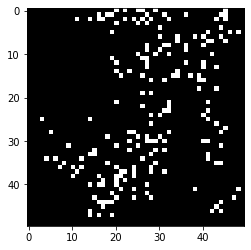

In [31]:
shap_mask = np.zeros((50,50,3))
# shap_img = cv2.imread(image_path)
for i in range(svs[0]):
  for j in range(svs[1]):
    if sv_p[i][j] == 1:
      shap_mask[i][j] = 255
    else:
      shap_mask[i][j] = 0

plt.imshow(shap_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


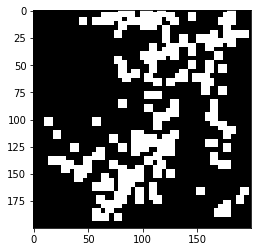

In [32]:
shap_mask_r = cv2.resize(shap_mask, (200, 200))
plt.imshow(shap_mask_r)

In [37]:
shap_mask_r.shape

(200, 200, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


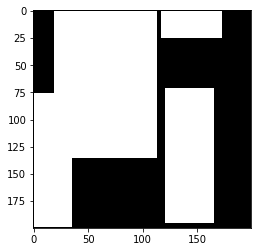

In [33]:
gt_mask = np.zeros(b_img.shape)

for l in range(len(boxes)):
  for i in range(boxes[l][1], boxes[l][3]):
    for j in range(boxes[l][0], boxes[l][2]):
      gt_mask[i][j] = 255 

plt.imshow(gt_mask)

In [34]:
intersection = np.logical_and(gt_mask, shap_mask_r)
union = np.logical_or(gt_mask, shap_mask_r)
iou_score = np.sum(intersection) / np.sum(union)
print("SHAP IOU: ",iou_score)

SHAP IOU:  0.15479558636299334


In [36]:
DATASET_ROOT = '/content/drive/My Drive/NEU surface defect database - test split/Test'
CLASSES = ['Cr', 'In', 'PS', 'Pa', 'RS', 'Sc']

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(DATASET_ROOT,
                                                    class_mode='categorical',
                                                    #interpolation='bilinear',
                                                    target_size=(200, 200),
                                                    batch_size=180,
                                                    shuffle=False,
                                                    classes=CLASSES)
unique, counts = np.unique(test_generator.labels, return_counts=True)
print(dict(zip(CLASSES, counts)))

Found 180 images belonging to 6 classes.
{'Cr': 30, 'In': 30, 'PS': 30, 'Pa': 30, 'RS': 30, 'Sc': 30}


In [0]:
test_input,y = test_generator.next()
print(test_input.shape)

#cur_batch_sz = 180

In [0]:
# #np.save('/content/drive/My Drive/xai_model/grad_test_input',test_input)
test_input = np.load('/content/drive/My Drive/xai_model/grad_test_input.npy')

In [0]:
test_crazing_idx = np.full(len(test_generator.filenames),False)
test_inclusion_idx = np.full(len(test_generator.filenames),False)
test_pitted_surface_idx = np.full(len(test_generator.filenames),False)
test_patches_idx = np.full(len(test_generator.filenames),False)
test_rolledin_scale_idx = np.full(len(test_generator.filenames),False)       
test_scratches_idx = np.full(len(test_generator.filenames),False)  
for i in range(len(test_generator.filenames)):
    for j in range(len(test_generator.filenames[i])):
        if test_generator.filenames[i][j]== "/":
            break
    correct_class = test_generator.filenames[i][0:j]
    if correct_class == "Cr":
        test_crazing_idx[i] = True
    if correct_class == "In":
        test_inclusion_idx[i] = True
    if correct_class == "PS":
        test_pitted_surface_idx[i] = True
    if correct_class == "Pa":
        test_patches_idx[i] = True
    if correct_class == "RS":
        test_rolledin_scale_idx[i] = True
    if correct_class == "Sc":
        test_scratches_idx[i] = True

# print(len(test_input[test_crazing_idx]))
# print(len(test_input[test_inclusion_idx]))
# print(len(test_input[test_pitted_surface_idx]))
# print(len(test_input[test_patches_idx]))
# print(len(test_input[test_rolledin_scale_idx]))
# print(len(test_input[test_scratches_idx]))